In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ROOT = "/home/ashank/Desktop/projects/project/kaggle/input/daisee/DAiSEE"

DATASET_PATH = f"{ROOT}/DataSet/Train"
LABELS_PATH = f"{ROOT}/Labels/TrainLabels.csv"
TRAIN_LIST = f"{ROOT}/Train.txt"

FRAME_SKIP = 5
EAR_THRESHOLD = 0.21

# Cognitive load computation
def cognitive_load(row):
    if row["Confusion"] >= 2 or row["Frustration"] >= 2:
        return 2   # HIGH
    elif row["Boredom"] >= 2:
        return 1   # MEDIUM
    else:
        return 0   # LOW

In [3]:
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

In [4]:
def extract_features(video_path):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.6
    )


    cap = cv2.VideoCapture(video_path)

    ear_values = []
    blink_count = 0
    closed_frames = 0
    motion_energy = []

    prev_landmarks = None
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb = np.ascontiguousarray(rgb)

        result = face_mesh.process(rgb)
        if not result.multi_face_landmarks:
            continue

        h, w, _ = frame.shape
        landmarks = result.multi_face_landmarks[0].landmark
        pts = np.array([(lm.x * w, lm.y * h) for lm in landmarks])

        left_eye = pts[LEFT_EYE]
        right_eye = pts[RIGHT_EYE]

        ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2
        ear_values.append(ear)

        if ear < EAR_THRESHOLD:
            closed_frames += 1
        else:
            if closed_frames >= 2:
                blink_count += 1
            closed_frames = 0

        if prev_landmarks is not None:
            motion_energy.append(np.linalg.norm(pts - prev_landmarks))

        prev_landmarks = pts

    cap.release()
    face_mesh.close()   # IMPORTANT

    if len(ear_values) == 0:
        return None

    return [
        float(np.mean(ear_values)),
        float(blink_count),
        float(np.mean(motion_energy) if motion_energy else 0.0)
    ]


In [5]:
import pandas as pd

labels_df = pd.read_csv(LABELS_PATH)
labels_df.columns = labels_df.columns.str.strip()

print(labels_df.head())
print("Rows:", len(labels_df))

           ClipID  Boredom  Engagement  Confusion  Frustration
0  1100011002.avi        0           2          0            0
1  1100011003.avi        0           2          0            0
2  1100011004.avi        0           3          0            0
3  1100011005.avi        0           3          0            0
4  1100011006.avi        0           3          0            0
Rows: 5358


In [6]:
labels_df["ClipID_str"] = (
    labels_df["ClipID"]
    .astype(str)
    .str.replace(".avi", "", regex=False)
)

labels_df["cog_load"] = labels_df.apply(cognitive_load, axis=1)

In [138]:
import os

DATA_ROOT = f"{DATASET_PATH}"

available_ids = set()

for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if f.endswith((".avi", ".mp4")):
            clip_id = os.path.splitext(f)[0]
            available_ids.add(clip_id)

print("Available clips:", len(available_ids))

Available clips: 512


In [139]:
high_ids = labels_df[
    (labels_df["cog_load"] == 2) &
    (labels_df["ClipID_str"].isin(available_ids))
]["ClipID_str"].tolist()

medium_ids = labels_df[
    (labels_df["cog_load"] == 1) &
    (labels_df["ClipID_str"].isin(available_ids))
]["ClipID_str"].tolist()

low_ids = labels_df[
    (labels_df["cog_load"] == 0) &
    (labels_df["ClipID_str"].isin(available_ids))
]["ClipID_str"].tolist()

print(len(low_ids), len(medium_ids), len(high_ids))

318 155 39


In [140]:
import random
import math

# Shuffle all
random.shuffle(low_ids)
random.shuffle(medium_ids)
random.shuffle(high_ids)

# Find max possible total based on smallest class
max_total = int(len(high_ids) / 0.30)

n_low = int(0.40 * max_total)
n_medium = int(0.30 * max_total)
n_high = int(0.30 * max_total)

print(n_low, n_medium, n_high)  # sanity check

selected_ids = (
    low_ids[:n_low] +
    medium_ids[:n_medium] +
    high_ids[:n_high]
)

random.shuffle(selected_ids)

print("Total selected:", len(selected_ids))

52 39 39
Total selected: 130


In [141]:
def find_video(filename):
    filename = str(filename)             
    clip_id = os.path.splitext(filename)[0]
    subject = clip_id[:6]

    path = f"{DATASET_PATH}/{subject}/{clip_id}/{filename}"
    return path if os.path.exists(path) else None

In [142]:
import collections

X, y = [], []

for vid in tqdm(selected_ids):
    vid_str = str(vid)  

    row = labels_df[labels_df["ClipID_str"] == vid_str]
    if row.empty:
        continue

    video_path = find_video(f"{vid_str}.avi")
    if video_path is None:
        continue

    features = extract_features(video_path)
    if features is None:
        continue

    X.append(features)
    y.append(row.iloc[0]["cog_load"])

print("Counter:", collections.Counter(y))
print("Total samples:", len(y))

  0%|                                                                                                  | 0/130 [00:00<?, ?it/s]I0000 00:00:1767512982.724554    3670 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1767512982.726093   22585 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.3.2-arch1.1), renderer: AMD Radeon Graphics (radeonsi, renoir, ACO, DRM 3.61, 6.12.63-1-lts)
  1%|▋                                                                                         | 1/130 [00:01<04:16,  1.99s/it]I0000 00:00:1767512984.713924    3670 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1767512984.715258   22623 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.3.2-arch1.1), renderer: AMD Radeon Graphics (radeonsi, renoir, ACO, DRM 3.61, 6.12.63-1-lts)
  2%|█▍                                                                                        | 2/130 [00:03<04:15,  1.99s/it]I0000 00:00:1767512986.

Counter: Counter({np.int64(0): 52, np.int64(2): 39, np.int64(1): 39})
Total samples: 130


In [156]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "max_leaf_nodes": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
}


cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
)

rf = RandomForestClassifier()

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=cv,
    n_jobs=-1
)

grid.fit(X, y)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 10, ...], 'max_leaf_nodes': [5, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [157]:
print("Best parameters:", grid.best_params_)
print("Best CV F1 score:", grid.best_score_)

Best parameters: {'max_depth': 10, 'max_leaf_nodes': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 score: 0.4000464541843852


In [158]:
best_rf = grid.best_estimator_

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
)

In [160]:
best_rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,5
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [161]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
)

gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [162]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=2,
    gamma="scale",
    probability=True,
    class_weight="balanced",
)

svm.fit(X_train, y_train)

,C,2
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [163]:
rf_pred = best_rf.predict(X_test)
gb_pred = gb.predict(X_test)
svm_pred = svm.predict(X_test)

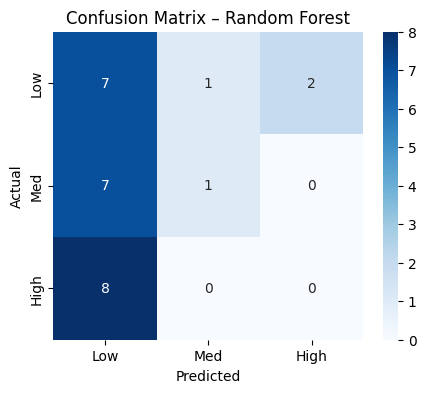

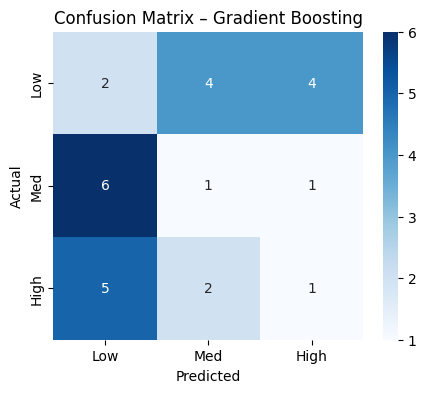

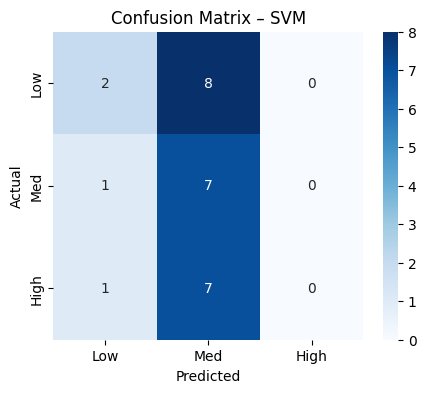

In [164]:
models_preds = {
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "SVM": svm_pred
}

for name, pred in models_preds.items():
    cm = confusion_matrix(y_test, pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Low", "Med", "High"],
        yticklabels=["Low", "Med", "High"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

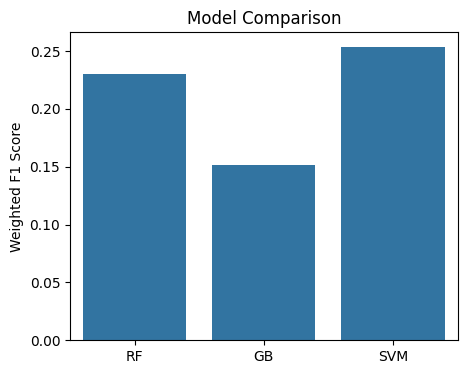

In [165]:
scores = {
    "RF": f1_score(y_test, best_rf.predict(X_test), average="weighted"),
    "GB": f1_score(y_test, gb.predict(X_test), average="weighted"),
    "SVM": f1_score(y_test, svm.predict(X_test), average="weighted")
}

plt.figure(figsize=(5,4))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.ylabel("Weighted F1 Score")
plt.title("Model Comparison")
plt.show()

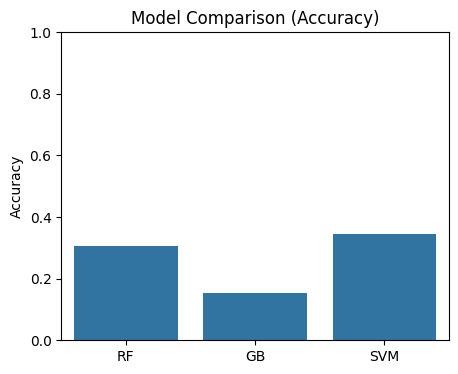

In [166]:
acc_scores = {
    "RF": accuracy_score(y_test, best_rf.predict(X_test)),
    "GB": accuracy_score(y_test, gb.predict(X_test)),
    "SVM": accuracy_score(y_test, svm.predict(X_test))
}

plt.figure(figsize=(5,4))
sns.barplot(x=list(acc_scores.keys()), y=list(acc_scores.values()))
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Comparison (Accuracy)")
plt.show()

In [167]:
acc_scores

{'RF': 0.3076923076923077,
 'GB': 0.15384615384615385,
 'SVM': 0.34615384615384615}

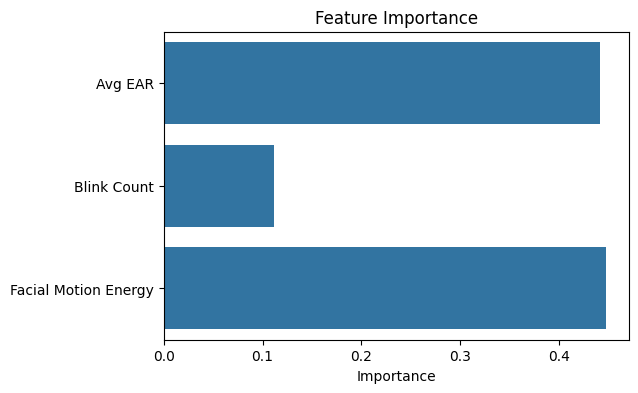

In [126]:
importances = best_rf.feature_importances_
features = ["Avg EAR", "Blink Count", "Facial Motion Energy"]

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

In [ ]:
import pickle

with open("cognitive_load_model.pkl","wb") as f:
    pickle.dump(best_rf,f)